# Classification Models

In [1]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df = df.rename(columns={'Category': 'label', 'Message': 'message'})
df = df[['label', 'message']]
df['label'] = df['label'].map({'ham': 0, 'spam': 1})


## Exploratory Data Analysis

### Data Overview

In [2]:
print(df.head())
print(df.info())
print(df.describe())

   label                                            message
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   int64 
 1   message  5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB
None
             label
count  5572.000000
mean      0.134063
std       0.340751
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


### Check for Missing Values

In [3]:
print(df.isnull().sum())

label      0
message    0
dtype: int64


### Data Visualization

#### Class Distribution (Spam vs. Ham)

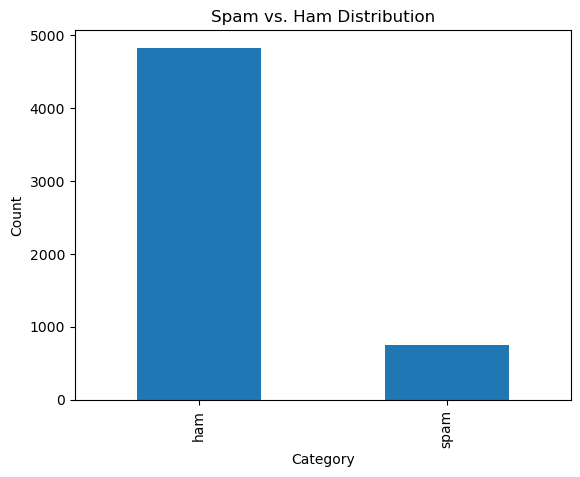

In [4]:
# Convert numerical labels back to categorical labels
df['label'] = df['label'].map({0: 'ham', 1: 'spam'})

# Plot the distribution with categorical labels
df['label'].value_counts().plot(kind='bar', title='Spam vs. Ham Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()


#### Message Length Analysis

Text(0.5, 1.0, 'Message Length Distribution')

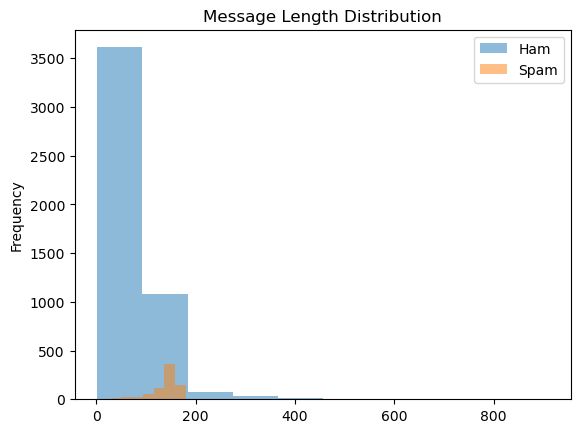

In [5]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1})
df['message_length'] = df['message'].apply(len)
df[df['label'] == 0]['message_length'].plot(kind='hist', alpha=0.5, label='Ham')
df[df['label'] == 1]['message_length'].plot(kind='hist', alpha=0.5, label='Spam')
plt.legend()
plt.title('Message Length Distribution')

#### Word Clouds for Spam and Ham Messages

[nltk_data] Downloading package stopwords to C:\Users\zh
[nltk_data]     wong\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


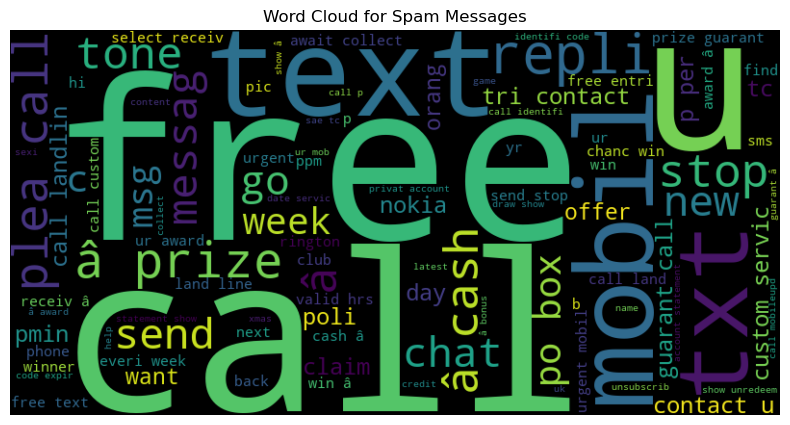

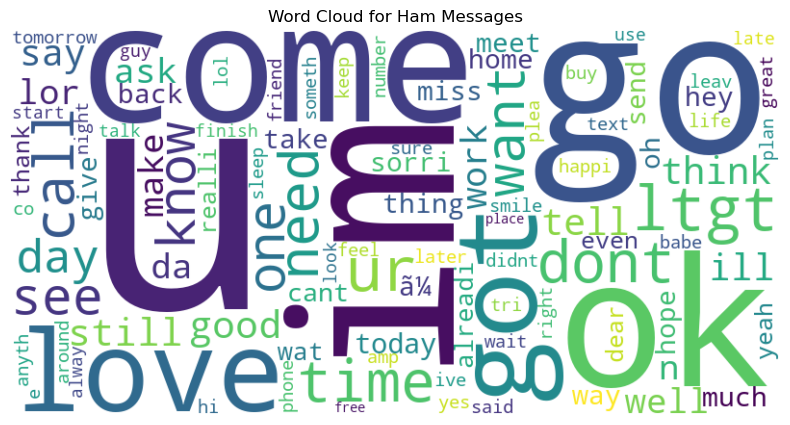

In [12]:
from wordcloud import WordCloud

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

def clean_message(message):
    words = message.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply stemming and stop word removal
df['message'] = df['message'].apply(clean_message)

# Create cleaned_message column
df['cleaned_message'] = df['message'].apply(clean_message)

# Word Cloud for Spam Messages
spam_words = ' '.join(df[df['label'] == 1]['cleaned_message'])
spam_wordcloud = WordCloud(width=800, height=400, background_color='black', max_words=100).generate(spam_words)

plt.figure(figsize=(10, 5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Spam Messages')
plt.axis('off')
plt.show()

# Word Cloud for Ham Messages
ham_words = ' '.join(df[df['label'] == 0]['cleaned_message'])
ham_wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(ham_words)

plt.figure(figsize=(10, 5))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Ham Messages')
plt.axis('off')
plt.show()


#### Top Words Frequency Plot for Spam and Ham

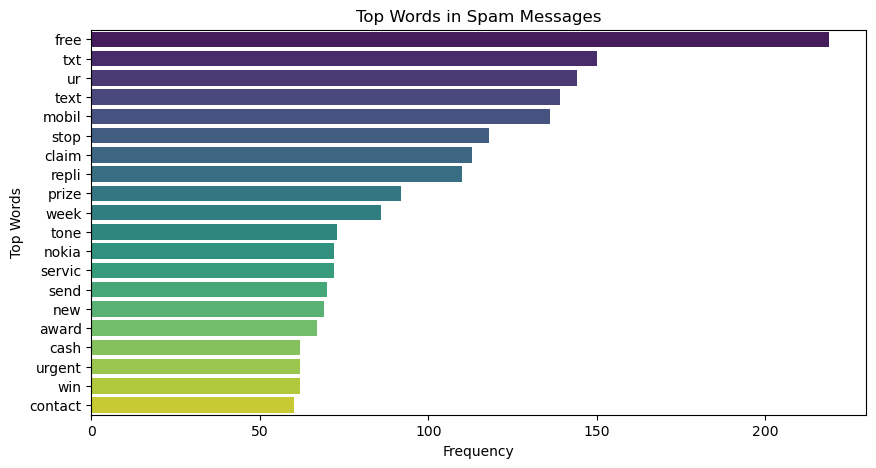

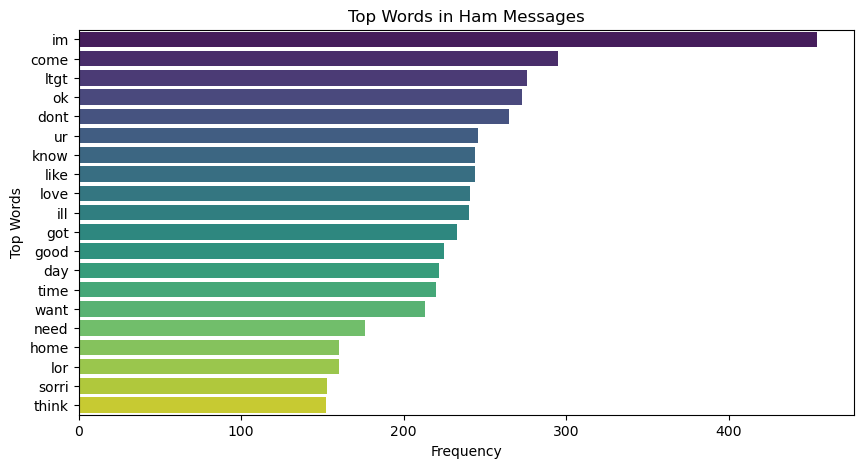

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_top_words(df, label, title):
    vectorizer = CountVectorizer(stop_words='english', max_features=20)
    words = vectorizer.fit_transform(df[df['label'] == label]['cleaned_message'])
    word_counts = words.sum(axis=0).A1
    word_freq = dict(zip(vectorizer.get_feature_names_out(), word_counts))
    
    word_freq_df = pd.DataFrame(word_freq.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(data=word_freq_df, x='count', y='word', palette='viridis')
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Top Words')
    plt.show()

# Plot top words for spam
plot_top_words(df, label=1, title='Top Words in Spam Messages')

# Plot top words for ham
plot_top_words(df, label=0, title='Top Words in Ham Messages')


## Data Preprocessing

In [14]:
# Text preprocessing functions
def preprocess_text(text):
    text = text.lower()  # Lowercasing
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespaces
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'http\S+|www.\S+', '', text)  # Remove URLs
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuations
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\d', '', text)  # Remove numeric values
    return text

# Apply preprocessing
df['message'] = df['message'].apply(preprocess_text)


## Text Vectorization

In [15]:
vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['message'])
y = df['label']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Random Forest Classification

In [16]:
# Hyperparameter Tuning
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize RandomizedSearchCV for Random Forest
rf_model = RandomizedSearchCV(RandomForestClassifier(), rf_param_grid, cv=3, n_iter=10, verbose=1, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Best parameters for Random Forest
print(f"Best parameters for Random Forest: {rf_model.best_params_}")

# Random Forest Predictions and Evaluation
rf_y_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_precision = precision_score(y_test, rf_y_pred)
rf_recall = recall_score(y_test, rf_y_pred)
rf_f1 = f1_score(y_test, rf_y_pred)
rf_conf_matrix = confusion_matrix(y_test, rf_y_pred)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}


### Random Forest Confusion Matrix

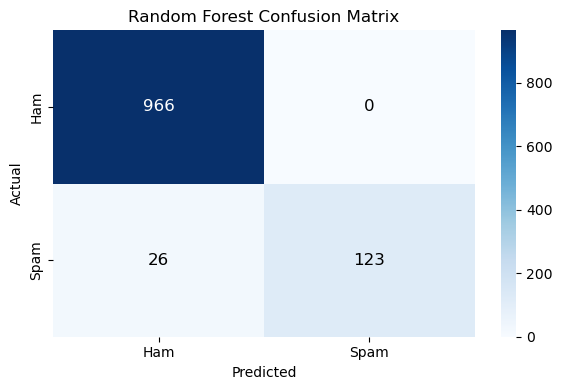

In [17]:
plt.figure(figsize=(6, 4))
ax = sns.heatmap(rf_conf_matrix, annot=False, cmap='Blues', 
                xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])

for i in range(rf_conf_matrix.shape[0]):
    for j in range(rf_conf_matrix.shape[1]):
        cell_value = rf_conf_matrix[i, j]
        cell_color = ax.collections[0].get_facecolors()[i * rf_conf_matrix.shape[1] + j]
        r, g, b, _ = cell_color
        luminance = 0.299 * r + 0.587 * g + 0.114 * b
        text_color = 'white' if luminance < 0.5 else 'black'
        ax.text(j + 0.5, i + 0.5, cell_value, ha='center', va='center', color=text_color, fontsize=12)

plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [19]:
print("\nRandom Forest Results")
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1 Score:", rf_f1)


Random Forest Results
Accuracy: 0.9766816143497757
Precision: 1.0
Recall: 0.825503355704698
F1 Score: 0.9044117647058824


## SVM Classification

In [20]:
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale']
}

# Initialize RandomizedSearchCV for SVM
svm_model = RandomizedSearchCV(SVC(probability=True), svm_param_grid, cv=3, n_iter=5, verbose=1, n_jobs=-1)
svm_model.fit(X_train, y_train)

# Best parameters for SVM
print(f"Best parameters for SVM: {svm_model.best_params_}")

# SVM Predictions and Evaluation
svm_y_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_y_pred)
svm_precision = precision_score(y_test, svm_y_pred)
svm_recall = recall_score(y_test, svm_y_pred)
svm_f1 = f1_score(y_test, svm_y_pred)
svm_conf_matrix = confusion_matrix(y_test, svm_y_pred)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters for SVM: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.1}


### SVM Confusion Matrix

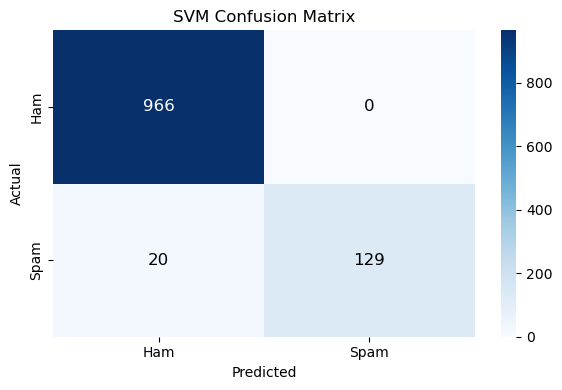

In [21]:
plt.figure(figsize=(6, 4))
ax = sns.heatmap(svm_conf_matrix, annot=False, cmap='Blues', 
                xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])

for i in range(svm_conf_matrix.shape[0]):
    for j in range(svm_conf_matrix.shape[1]):
        cell_value = svm_conf_matrix[i, j]
        cell_color = ax.collections[0].get_facecolors()[i * svm_conf_matrix.shape[1] + j]
        r, g, b, _ = cell_color
        luminance = 0.299 * r + 0.587 * g + 0.114 * b
        text_color = 'white' if luminance < 0.5 else 'black'
        ax.text(j + 0.5, i + 0.5, cell_value, ha='center', va='center', color=text_color, fontsize=12)

plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [22]:
print("\nSVM Results")
print("Accuracy:", svm_accuracy)
print("Precision:", svm_precision)
print("Recall:", svm_recall)
print("F1 Score:", svm_f1)


SVM Results
Accuracy: 0.9820627802690582
Precision: 1.0
Recall: 0.8657718120805369
F1 Score: 0.9280575539568345
